In [10]:
%matplotlib notebook
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import mpl_toolkits.mplot3d.axes3d as axes3d
import pandas as pd
import ipympl
import warnings
from scipy import signal
from scipy.signal import chirp, find_peaks, peak_widths
import matplotlib.pyplot as plt
import numpy as np
import peakutils
from scipy import interpolate

warnings.simplefilter("ignore")


### VIsualize 2D Array

<IPython.core.display.Javascript object>


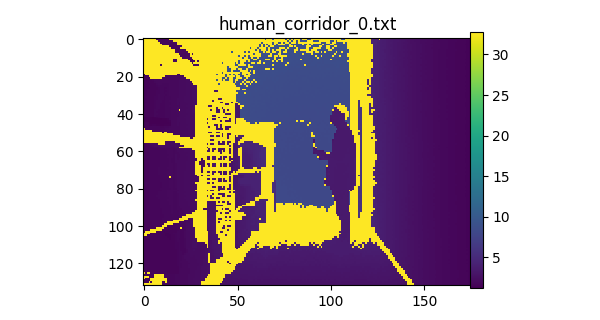

<IPython.core.display.Javascript object>


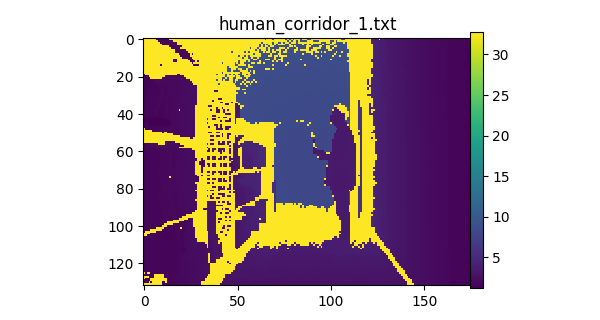

<IPython.core.display.Javascript object>


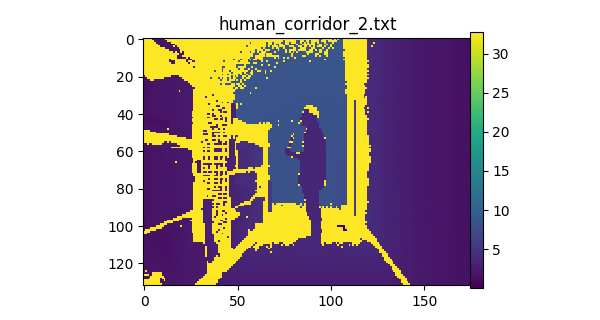

In [2]:
def visualize(H, title):
    fig = plt.figure(figsize=(6, 3.2))

    ax = fig.add_subplot(111)
    ax.set_title(title)

    plt.imshow(H)
    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    
    plt.show()
    
data=[]
for i in range(0,3):
    data.append(np.loadtxt("human_wall_distance_task_5/human_corridor_%s.txt"%i))
    visualize(data[i-1], "human_corridor_%s.txt"%i)

### Historgram of Distances in Depth Map 

<IPython.core.display.Javascript object>


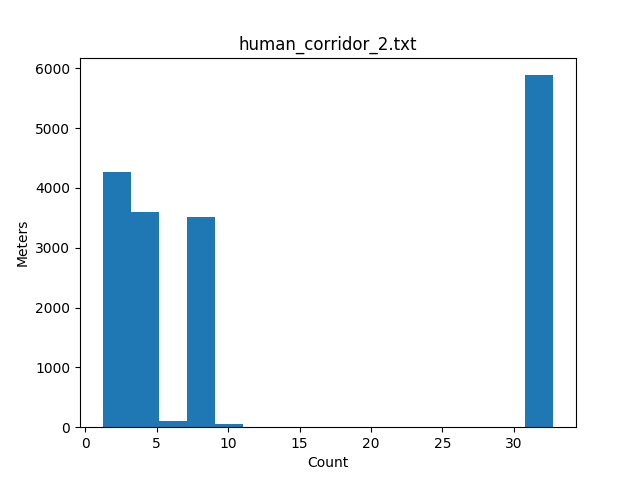

In [3]:
# THE INDEX OF THE TEXT FILE TO ANALYZE
txtFile=2

zs_contrast=[]
xs=[]
ys=[]
zs=[]
humanMaxDistance=4
humanMinDistance=3
for a in range(0,data[txtFile].shape[0]):
    for b in range(0,data[txtFile].shape[0]):        
        xs.append(a)
        ys.append(b)
        zs.append(data[txtFile][a][b])

        if(data[txtFile][a][b]>=humanMinDistance and data[txtFile][a][b]<humanMaxDistance):
            zs_contrast.append(data[txtFile][a][b])
        else:
            zs_contrast.append(-100)
            
            
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("human_corridor_%d.txt"%txtFile)
ax.set_xlabel("Count")
ax.set_ylabel("Meters")
plt.hist(zs, bins='auto')
plt.show()

### Assumptions

* Human is always 2 meters away
* Corridors are always 1.5 meters in width
* There is a single human in the coridor 
* Robot is centered in the center of the coridor
* Camera has 70 degrees horizontal field of view and 50 degrees vertical field of view

### 3D visualization of Depth Map

<IPython.core.display.Javascript object>


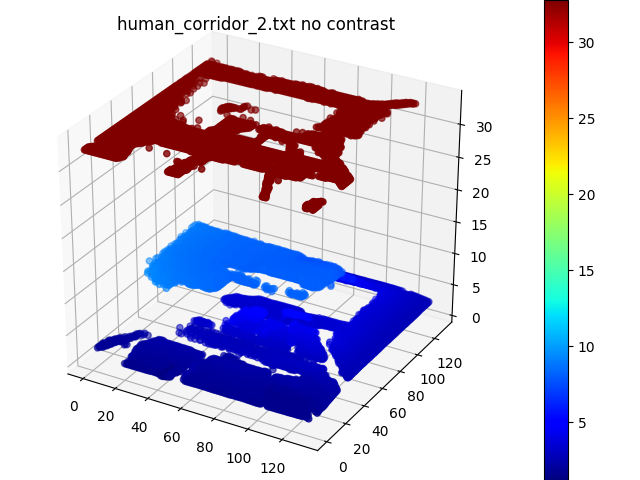

<IPython.core.display.Javascript object>


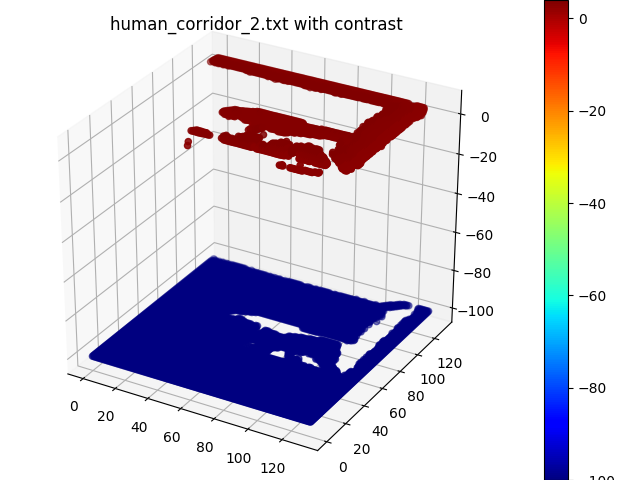

In [4]:



def scatter3d(x,y,z, cs,title, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    ax.set_title('human_corridor_%d.txt %s'%title)
    plt.show()
    


scatter3d(xs,ys , zs,zs, (txtFile,'no contrast'))

scatter3d(xs,ys , zs_contrast,zs_contrast, (txtFile,'with contrast'))

<IPython.core.display.Javascript object>


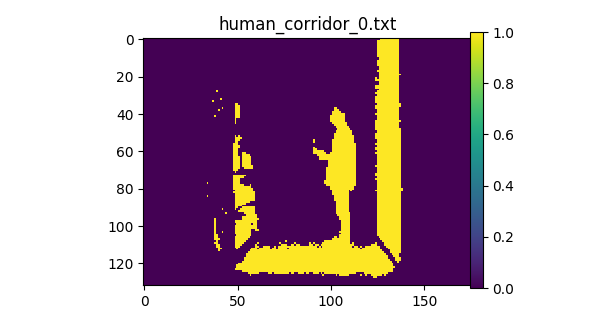

<IPython.core.display.Javascript object>


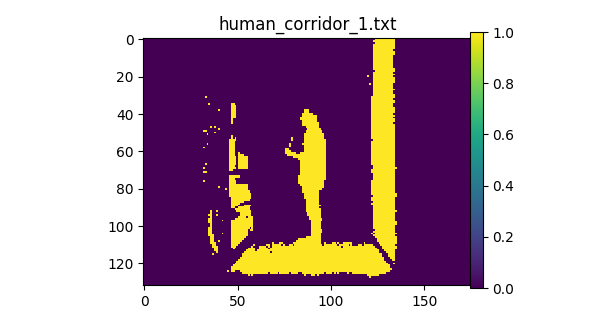

<IPython.core.display.Javascript object>


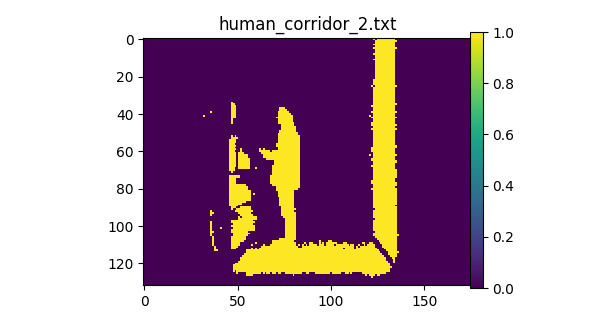

In [5]:
#Based on the data we are interested in
dataContrasted=[]
for i in range(0,3):
    tmp=(data[i]>humanMinDistance)
    tmp1=(data[i]<humanMaxDistance)
    dataContrasted.append(np.logical_and(tmp,tmp1).astype(int))
    visualize( dataContrasted[i],'human_corridor_%d.txt'%i)

### Convert Image to 1D Signal and find Peaks

<IPython.core.display.Javascript object>


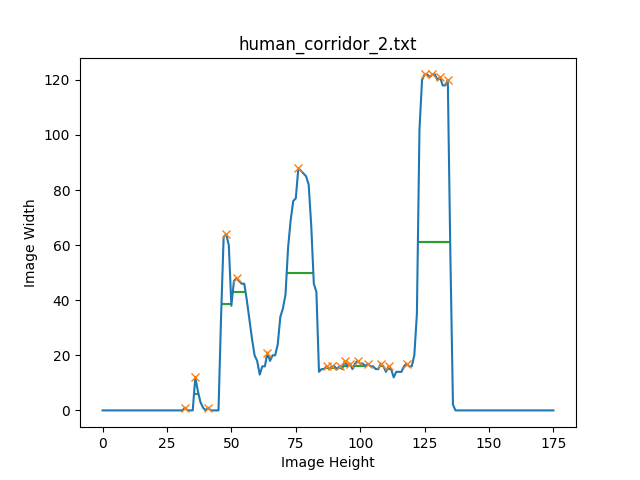

In [6]:


#Convert to a signal for easier processing
x=dataContrasted[txtFile].sum(axis=0)[:]
#Find peaks of the signal
peaks, _ = find_peaks(x)
#Find the widths of the peaks
peakWidths = peak_widths(x, peaks, rel_height=0.5)


fig = plt.figure()
axs=fig.add_subplot(111)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.hlines(*peakWidths[1:], color="C2")
axs.set_ylabel("Image Width")
axs.set_xlabel("Image Height")
axs.set_title('human_corridor_%d.txt'%txtFile)

plt.show()


### Remove Signal Noise

<IPython.core.display.Javascript object>


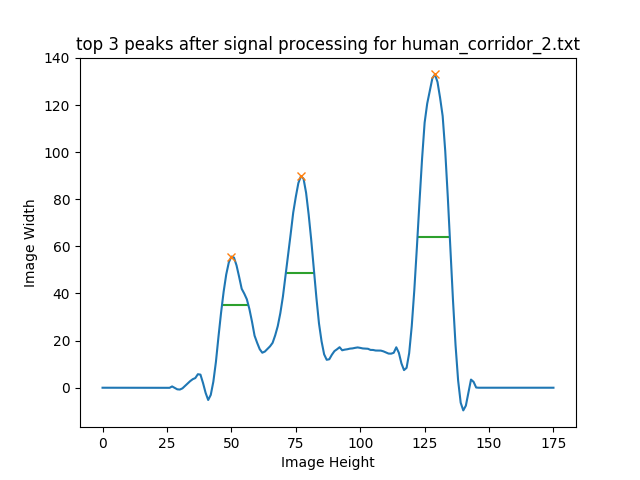

In [7]:

xFiltered=signal.savgol_filter(x, 19, 4)
cb = np.array(xFiltered)

indexes = peakutils.indexes(cb, thres=0.02/max(cb), min_dist=10)

peaks=sorted(zip(xFiltered[indexes],indexes),key=lambda a : a[0], reverse=True)[:3]

peaks = [xFiltered[1] for xFiltered in peaks]

fig = plt.figure()
axs=fig.add_subplot(111)
plt.plot(xFiltered)
plt.plot(peaks, xFiltered[peaks], "x")

peakWidths = peak_widths(xFiltered, peaks, rel_height=0.5)
plt.hlines(*peakWidths[1:], color="C2")

axs.set_ylabel("Image Width")
axs.set_xlabel("Image Height")
axs.set_title('top 3 peaks after signal processing for human_corridor_%d.txt'%txtFile)

plt.show()



### List of intercept at worst case scenario e.g. that minimize the clearance

In [8]:
def findYIntercepts(yToFind, y,x):
    yreduced = np.array(y) - yToFind
    freduced = interpolate.UnivariateSpline(x, yreduced, s=0)
    return freduced.roots()

def sumOddPairLineWidth(points):
    widthSum=0
    points=points[1:]
    points=points[:-1]
    for pointTuple in zip(points[::2], points[1::2]):
        widthSum+=(pointTuple[1]-pointTuple[0])
    return widthSum

def isPeakInWidthPair(points, peaks):
    #peaks are ordered
    points=sorted(points)
    peaks=sorted(peaks)
    #print(points)
    #print(peaks)
    for idx,pointTuple in enumerate(zip(points[::2], points[1::2])):
        #print(pointTuple[0],pointTuple[1])
        #print(peaks[idx])
        if not (peaks[idx]>pointTuple[0] and pointTuple[1]>peaks[idx]):
            return False
    return True


widthSums=[]
for i in np.linspace(0,len(x),len(x)):
    intercepts=findYIntercepts(i,x,range(0,len(x)))
    if(len(intercepts)==6 and isPeakInWidthPair(intercepts, peaks) ):
        widthSums.append({"sum":sumOddPairLineWidth(intercepts),"y":i,"x":intercepts})
        
minWidthSum=sorted(widthSums,key=lambda a : a["sum"], )[:1][0]
minWidthSum.pop("sum")
pd.DataFrame(minWidthSum)

,y,x
0,21.12,45.681944
1,21.12,58.733650
2,21.12,67.535163
3,21.12,83.721399
4,21.12,121.441470
5,21.12,135.528914


### Calculate the Clearance for Each Intercept and Visualize

d1 0.200034m and d2 0.857274m
Right with d2 0.857274m


<IPython.core.display.Javascript object>


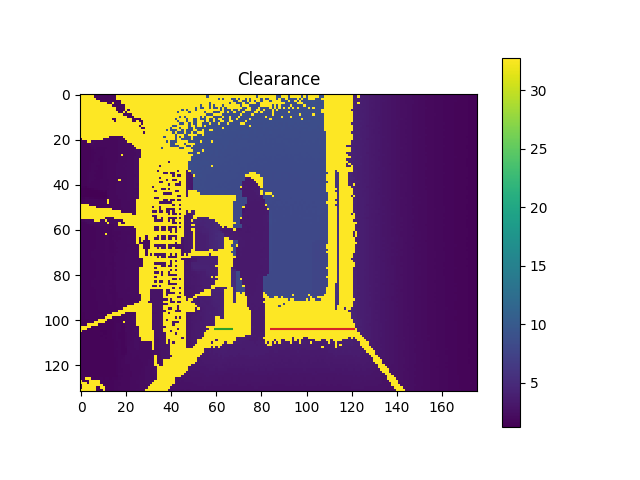

In [9]:
# Avoid using signal to calculate clearance distance because the distance of the person is already off from what was described. 
# Hence do it manually directly from the photo
def calculatePerspectiveDistance(x):
    coeff=0.02272727272
    return coeff*x
intercepts=minWidthSum["x"]
d1=calculatePerspectiveDistance(intercepts[2]-intercepts[1])
d2=calculatePerspectiveDistance(intercepts[4]-intercepts[3])

print("d1 %fm and d2 %fm"%(d1,d2))
if(d1>d2):
    print("Left with d1 %fm"%d1)

else:
    print("Right with d2 %fm"%d2)
    
# VISUALIZE THE RESULTS
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Clearance')
plt.imshow(data[txtFile])
ax.set_aspect('equal')
plt.colorbar(orientation='vertical')
#D1
plt.hlines(125-minWidthSum["y"],intercepts[1],intercepts[2], color="C2")
#D2
plt.hlines(125-minWidthSum["y"],intercepts[3],intercepts[4], color="C3")
plt.show()
